In [1]:
### librerias lectura y visualizacion
import pandas as pd
import numpy as np
import plotly.express as px
import os
import warnings
warnings.simplefilter("ignore")
pd.options.display.max_columns = None
import seaborn as sns

#### librerias para procesamiento y modelado
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import joblib
### libreria exportar modelos
import joblib
import panel as pn
### libreria tiempo ejecucion
from tqdm import tqdm
from scipy.stats import chi2_contingency
### libraria para graficos
import panel as pn
### libreia metricas
from sklearn.metrics import classification_report,roc_auc_score

#### Lectura del Dataframe


In [2]:
ruta_proce = "../data/raw/"

In [3]:
#### Clase para procesamiento, lectura y visualización
class ProcesamientoInicial:
    def __init__(self,ruta):
        self.ruta=ruta
        self.df= pd.read_csv(os.path.join(self.ruta,"diabetic_data.csv"))
        self.categorias = pd.read_csv(os.path.join(self.ruta,"IDs_mapping.csv"),header=None,sep=",")
    def Procesamientocategoriascodigos(self):
        self.categorias.dropna(how='all',inplace=True)
        ### vamos a buscar las posiciones para filtral el dataframe
        positions=[list(self.categorias[0]).index("admission_type_id"),
        list(self.categorias[0]).index("discharge_disposition_id"),
        list(self.categorias[0]).index("admission_source_id")]
        #### dividimos el dataframe en subconjuntos y los guardamos en un diccionario
        dataframes = {}
        dataframes['admission_type_id']=self.categorias.iloc[positions[0]:positions[1]].reset_index(drop=True)
        dataframes['discharge_disposition_id']=self.categorias.iloc[positions[1]:positions[2]].reset_index(drop=True)
        dataframes['admission_source_id']=self.categorias.iloc[positions[2]:].reset_index(drop=True)

        self.dataframes = dataframes
    def Cambiocategorias(self):
        ### transformamos el tipo de dato para el bucle
        self.df['admission_type_id'] = self.df['admission_type_id'].apply(lambda x: str(x))
        self.df['discharge_disposition_id'] = self.df['discharge_disposition_id'].apply(lambda x: str(x))
        self.df['admission_source_id'] = self.df['admission_source_id'].apply(lambda x: str(x))
        #### for que va a cambiar el código de cada tipo de caregoria
        for var in tqdm(['admission_type_id','discharge_disposition_id','admission_source_id']):
            for admin in self.df.index:
                paso1 = self.df.at[admin,var]
                df_paso = self.dataframes[var].drop(0)
                
                for das in df_paso[0]:
                    if paso1==str(das):
                        self.df.at[admin,var] = df_paso.loc[df_paso[0]==das,1].values[0]
                        continue
    def Cambiosignodataframe(self):
        ### en el dataframe los valores con ? son los que se encuentran vacios
        for kan in self.df.columns:
            if self.df[kan].dtype=='object':
                self.df.loc[self.df[kan]=="?",kan]=None

    def Removiendocolumnasvacios(self):
        ### vamos a ver que columnas tiene valores vacios para saber si las dejamos o las quitamos
        diccionario = dict(self.df.isnull().sum()/self.df.shape[0])
        new_dictionary = dict(filter(lambda x: x[1]<0.3, diccionario.items()))
        ### quitamos las variables que tienen más del 30% de valores vacios
        df_new = self.df[list(new_dictionary.keys())]
        self.df_new = df_new.copy()
    def PruebaChi(self):
        ### vamos a calcular la prueba chi cuadrado para verficiar si es bueno añadir o no algunas variables caregoricas al modelo
        
        pruebca_chi = {}
        for hakim in self.df_new.select_dtypes(['object']).columns:
            stat, p, dof, expected = chi2_contingency(pd.crosstab(self.df_new['readmitted'],self.df_new[hakim]))
            pruebca_chi[hakim] = p
        variables_prueba_chi = dict(filter(lambda x: x[1]<0.05, pruebca_chi.items())).keys()
        variables_numericas = list(self.df_new.select_dtypes([np.number]).columns)
        variables_numericas.remove('encounter_id')
        variables_numericas.remove('patient_nbr')
        df_modelo = self.df_new[variables_numericas+list(variables_prueba_chi)]
        self.df_modelo = df_modelo.copy()
    


In [4]:
#### Clase para procesamiento y modelado
class Modelado:
    def __init__(self,df_modelo):
        self.df_modelo = df_modelo
        self.ruta_modelos = "../models/"
    def Division_X_y(self):
        self.X = self.df_modelo.drop(['readmitted'],axis=1)
        self.y= self.df_modelo[['readmitted']]
        self.col_categoricos = self.X.select_dtypes("object").columns
        self.col_numericos = self.X.select_dtypes(np.number).columns
    def Definicion_modelos(self):
        ## Lista para añadir modelos para ejecución
        self.clsf = []
        self.clsf.append(LogisticRegression(random_state=19))
        self.clsf.append(RandomForestClassifier(n_estimators=50,random_state=19))
        self.clsf.append(GradientBoostingClassifier(n_estimators=50,random_state=19))
        self.clsf.append(AdaBoostClassifier(n_estimators=50,random_state=19))
        self.clsf.append(AdaBoostClassifier(random_state=19))
    def Modelo(self):
        #### imputación de datos
        
        self.resultados = {}
        for i in self.clsf:
            print("Ejecutando el modelo: ", i)
            label = LabelEncoder()
            impute = SimpleImputer(strategy='mean')
            numeric_transformer = StandardScaler()
            categorical_transformer = OneHotEncoder()
            preprocessor = ColumnTransformer(
                    transformers=[
                        ("imputer", impute,self.col_numericos),
                        ("categorical",categorical_transformer,self.col_categoricos),
                            ("numerico",numeric_transformer, self.col_numericos)
                        ]
                )
            clf = Pipeline(
                    steps=[('preprocessor',preprocessor)]
                )
            clf_modelo = Pipeline(
                    steps=[("Preprocesando",clf),("Modelando",i)]
                )

                #### 
                
            X_train,self.X_test,y_train,self.y_test = train_test_split(self.X,self.y,test_size=0.3
                            ,stratify=self.y,random_state=19)
            clf_modelo.fit(self.X,self.y)
            print("Score: ",clf_modelo.score(self.X_test,self.y_test))
            self.resultados[f'{i}'] = clf_modelo.score(self.X_test,self.y_test)

            #### exportando el modelo
            joblib.dump(clf_modelo,os.path.join(self.ruta_modelos,f"{i}.pkl"))
    def Eval(self,name_model):
        from sklearn.metrics import classification_report
        modelo_pr = joblib.load(os.path.join(self.ruta_modelos,f'{name_model}.pkl'))
        prediccion = modelo_pr.predict(self.X_test)
        return print(classification_report(self.y_test,prediccion))

### Lectura, Preprocesamiento y Visualización

In [5]:
objeto1 = ProcesamientoInicial(ruta_proce)
objeto1.Procesamientocategoriascodigos()
objeto1.Cambiocategorias()
objeto1.Cambiosignodataframe()
objeto1.Removiendocolumnasvacios()
objeto1.PruebaChi()

100%|██████████| 3/3 [02:48<00:00, 56.01s/it]


In [6]:
df_new = objeto1.df_new

### Análisis Exploratorio de los Datos

vamos a revisar algunas variables para ver su comportamiento

In [7]:
df_new.describe()

,encounter_id,patient_nbr,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


<AxesSubplot:>

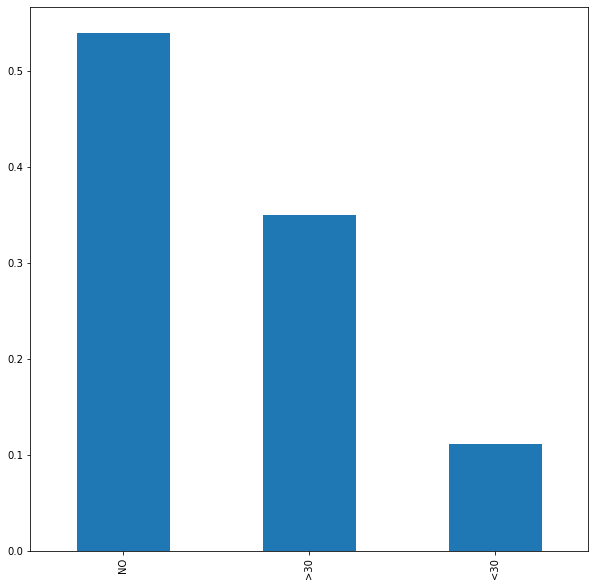

In [8]:
#### proporción readmitted
df_new['readmitted'].value_counts(normalize=True).plot(kind='bar', figsize=(10,10))

In [9]:

def App_grafico(df_frame_ingreso):
    select_origin = pn.widgets.Select(options= list(df_frame_ingreso.select_dtypes('object').columns), name = "Variables")
    @pn.depends(select_origin)
    def crea_grafica_1(select_origin):
        df_group = df_frame_ingreso.groupby([select_origin,'readmitted'],as_index=False).size()
        df_group = df_group.merge(df_group.groupby([select_origin],as_index=False).sum(),on=select_origin)
        df_group['porcentaje'] = df_group['size_x']/df_group['size_y']
        fig = px.bar(df_group,x=select_origin,color='readmitted',y='porcentaje', barmode='group')
        return fig
    return pn.Column(select_origin,crea_grafica_1).save(f'../data/processed/graficos.html', embed=True)

In [10]:
### creamos el html para ver las variables
App_grafico(df_new)
##3 si se desea ver vaya a la siguiente ruta y abra el html /data/processed/graficos.html

In [11]:
def App_grafico_histogram(df_frame_ingreso):
    select_origin = pn.widgets.Select(options= list(df_frame_ingreso.select_dtypes(np.number).columns), name = "Variables")
    select_destin = pn.widgets.Select(options= list(df_frame_ingreso.select_dtypes(np.number).columns), name = "Variables2")
    @pn.depends(select_origin,select_destin)
    def crea_grafica_1(select_origin,select_destin):
        fig = px.histogram(df_frame_ingreso, x=select_origin,nbins=100, color='readmitted',template="plotly_white")
        return fig
    return pn.Column(select_origin,crea_grafica_1).save(f'../data/processed/graficos_histogram.html', embed=True)

In [12]:
App_grafico_histogram(df_new)
##3 si se desea ver vaya a la siguiente ruta y abra el html /data/processed/graficos_histogram.html

#### Procesamiento y preparación de los datos para modelo

In [13]:
def Cambiolabel(var):
    if var=='NO':
        return 0
    elif var=='>30':
        return 1
    elif var=='<30':
        return 2
    else:
        return "Error"

In [14]:
modelo = objeto1.df_modelo.copy()
modelo['readmitted'] = modelo['readmitted'].apply(Cambiolabel)

### Análisis Confirmatorio y Procesamiento features

In [15]:
objeto2 = Modelado(modelo)
objeto2.Division_X_y()
objeto2.Definicion_modelos()
objeto2.Modelo()


Ejecutando el modelo:  LogisticRegression(random_state=19)
Score:  0.5823124795283328
Ejecutando el modelo:  RandomForestClassifier(n_estimators=50, random_state=19)
Score:  0.9999672453324598
Ejecutando el modelo:  GradientBoostingClassifier(n_estimators=50, random_state=19)
Score:  0.5884376023583361
Ejecutando el modelo:  AdaBoostClassifier(random_state=19)
Score:  0.5862102849656076
Ejecutando el modelo:  AdaBoostClassifier(random_state=19)
Score:  0.5862102849656076


### Evaluación

In [17]:
### validación score
objeto2.resultados

{'LogisticRegression(random_state=19)': 0.5823124795283328,
 'RandomForestClassifier(n_estimators=50, random_state=19)': 0.9999672453324598,
 'GradientBoostingClassifier(n_estimators=50, random_state=19)': 0.5884376023583361,
 'AdaBoostClassifier(random_state=19)': 0.5862102849656076}

In [18]:
objeto2.Eval('LogisticRegression(random_state=19)')

              precision    recall  f1-score   support

           0       0.60      0.87      0.71     16459
           1       0.51      0.32      0.39     10664
           2       0.40      0.01      0.03      3407

    accuracy                           0.58     30530
   macro avg       0.50      0.40      0.38     30530
weighted avg       0.55      0.58      0.52     30530



#### Resumen aspectos importantes

##### AED
- En el análisis exploratorio de los datos se observa que personas que son de readmisión el 28% vienen de otras clínicas
y apenas directo a urgencias 37%
- Las personas que se encuentran entre los 20 y 30 años, vuelven en mayor frecuencia (14%) antes de los 30 días
que personas que están entre los 50-60 años con apenas el 9% 
- En el caso de la raza, las personas caucasicas son las que más vuelven a ser readmitidos (35%)
- Las personas que tienen los niveles de glucosa por encima de 300, son las más recurrentes en volver,
tanto antes de los 30 días (14%) como las que vuelven despues de 30 días (41%)
- Las personas que vuelven antes de los 30 días se practican en mayor parte 40-44 pruebas, pueden ser personas 
que esten en algún tratamiento especifico

##### ACD


Se utilizaron modelos de ensamble, debido a la alta variablidad de los datos son los más adecuados para ello
además se disminuyó el valor de los estimadores, ya qué, el tiempo de ejecución era muy alto, sin embargo
también se utilizó regresión logística

- El modelo de random forest tiene un problema de sobreajuste, se observan las métricas iguales a 1, lo cual supone
un fallo en el mismo, el cual puede estar dado por los estimadores que se disminuyeron.
- En terminos generales, el modelo de gradient boosting arrojó un valor un poco mayor que adabost, no mucho
y tampoco es muy bueno 0.6, además al revisar las métricas por ejempo el recall no es muy bueno en la categoria 2,
la cual corresponde a menos de 30 días, y estó reflejaría una falla en encontrar potenciales personas que volverian
en ese tiempo
- Es necesario para mejorar el modelo rebalancear la muestra, utilizando metodología SMOTE
- La regresión logística a pesar de ser un algoritmo menos potente mostró mejor resultado que RandomForest

